In [127]:
import numpy as np
import matplotlib.pyplot as plt

In [128]:
hsi_raw = np.load("data/hyperspectral.npy")

In [129]:
rgb_bands = [54, 32, 18]
hsi_rgb = hsi_raw[:, :, rgb_bands]
hsi_rgb = (
    hsi_rgb / hsi_rgb.max()
)

pmin, pmax = np.percentile(hsi_rgb, (1, 95), axis=(0, 1))
hsi_rgb_pimped = hsi_rgb.copy()
for i in range(pmin.size):
    hsi_rgb_pimped[:, :, i] = (hsi_rgb[:, :, i] - pmin[i]) / (pmax[i] - pmin[i])
hsi_rgb_pimped[hsi_rgb_pimped < 0] = 0
hsi_rgb_pimped[hsi_rgb_pimped > 1] = 1

Shadow detection

In [130]:
import skimage.morphology as sm

In [131]:
def detect_shadows_mask(hsi_image):
    m_intensity = np.mean(hsi_image, axis=2)
    threshold = np.percentile(m_intensity, 11)
    mask = m_intensity < threshold
    return mask

def detect_shadows(hsi_image):
    mask = detect_shadows_mask(hsi_image)
    shadow_pp = sm.opening(mask, sm.square(3))
    shadow_pp = sm.closing(shadow_pp, sm.disk(25))
    return shadow_pp

In [132]:
shad_mask = detect_shadows(hsi_raw)

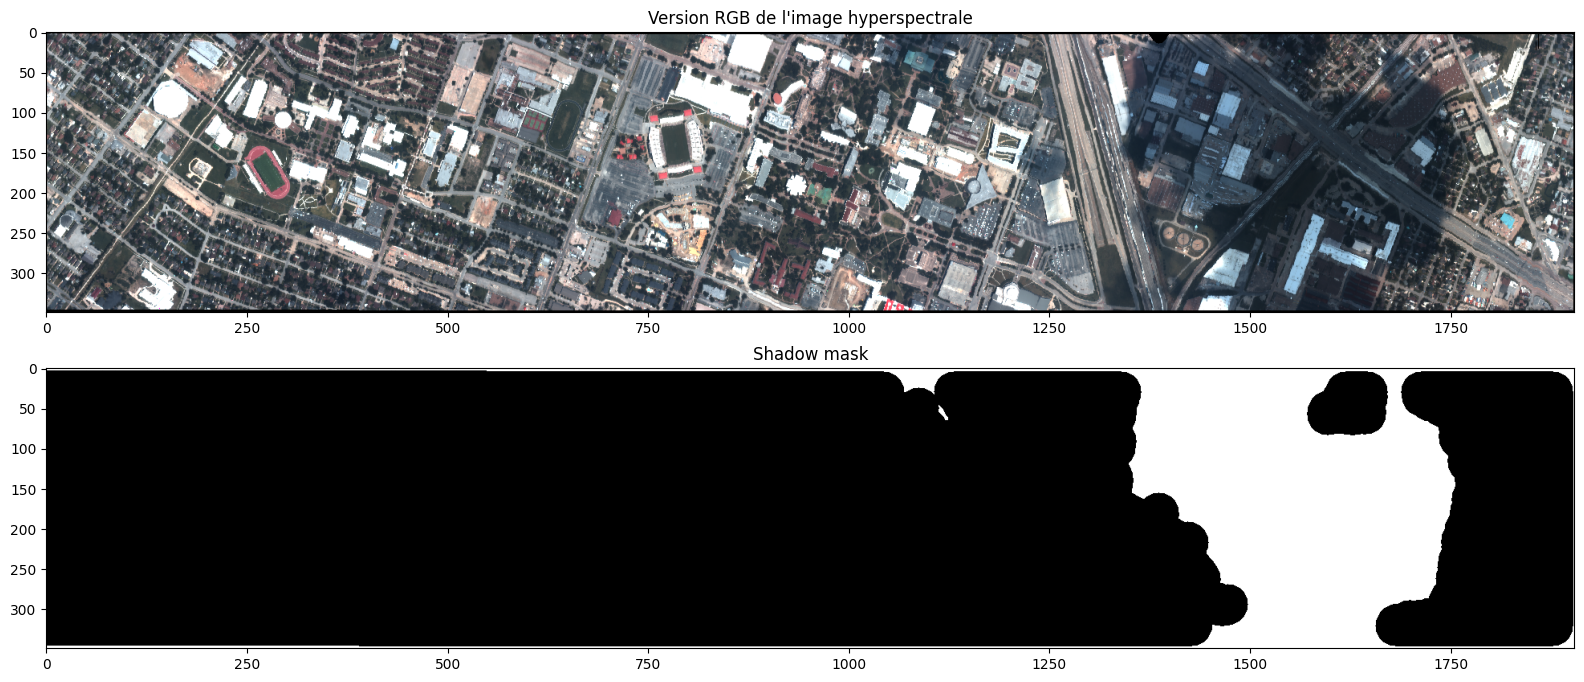

In [133]:
plt.figure(figsize=(20, 8))
plt.subplot(211)
plt.title("Version RGB de l'image hyperspectrale")
plt.imshow(hsi_rgb_pimped)
plt.subplot(212)
plt.title("Shadow mask")
plt.imshow(shad_mask, cmap="gray")
plt.show()

Increasing of intensity in shadowed area  

In [170]:
new_img = hsi_rgb_pimped.copy()
new_img[shad_mask] *= 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


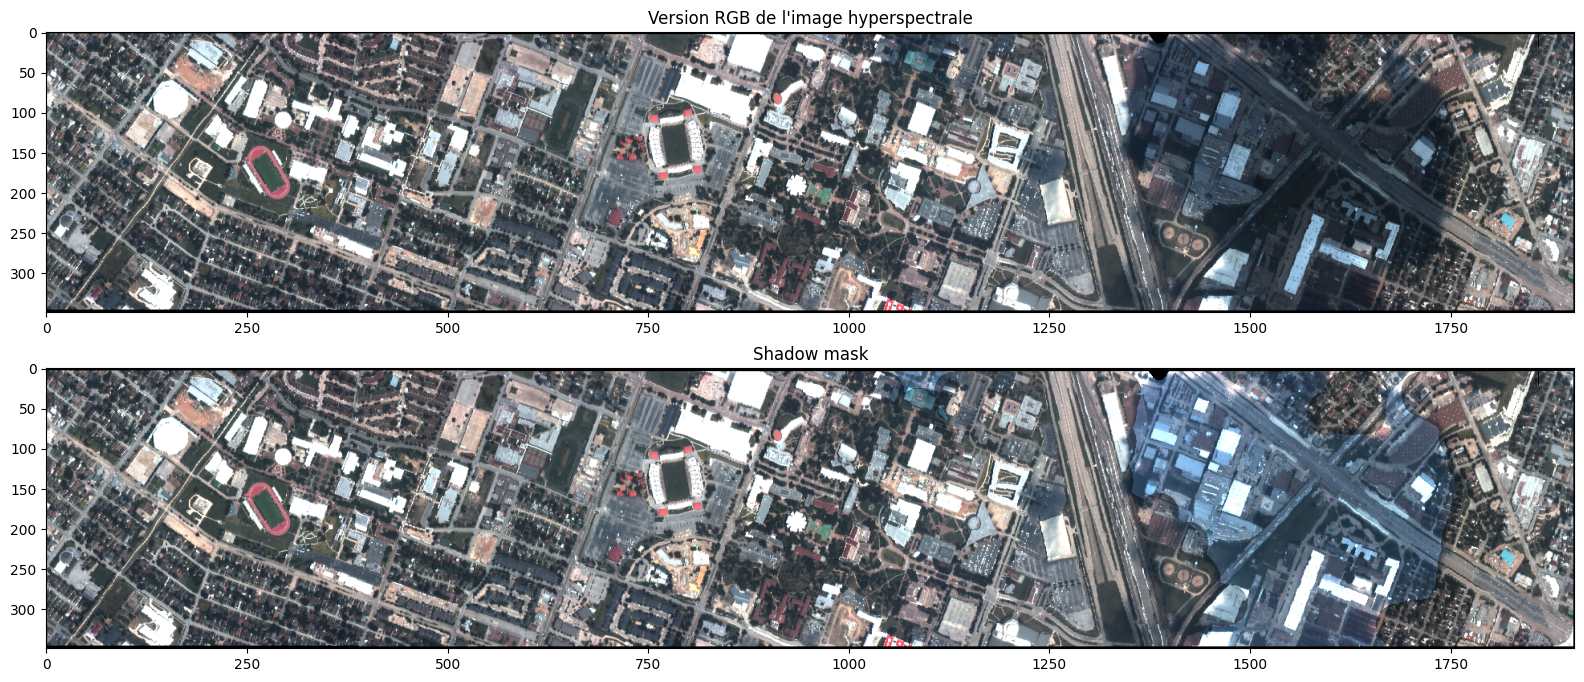

In [171]:
plt.figure(figsize=(20, 8))
plt.subplot(211)
plt.title("Version RGB de l'image hyperspectrale")
plt.imshow(hsi_rgb_pimped)
plt.subplot(212)
plt.title("Shadow mask")
plt.imshow(new_img, cmap="gray")
plt.show()

Add shadow detection future in hsi_image

In [136]:
hsi_raw_shadow = np.concatenate((hsi_raw, shad_mask[:, :, np.newaxis]), axis=2)
hsi_raw_shadow.shape

(349, 1905, 145)

In [137]:
lidar = np.load("data/lidar.npy")
hsi_raw_shadow = np.concatenate((hsi_raw_shadow, lidar[:, :, np.newaxis]), axis=2)
hsi_raw_shadow.shape

(349, 1905, 146)

In [153]:
hsi_raw_shadow = np.concatenate((hsi_raw_shadow, new_img[:, :, :]), axis=2)
hsi_raw_shadow.shape

(349, 1905, 149)

Building classifier

In [154]:
from utils import Classes
from discriminator_classifier import DiscriminatorClassifier

In [155]:
groundtruth = np.load("groundtruth/groundtruth.npy").reshape(-1)
idx = groundtruth.nonzero()[0]
h = hsi_raw_shadow.reshape(-1, 149)
X = h[idx]
y = groundtruth[idx]
X.shape, y.shape


((2832, 149), (2832,))

In [156]:
classes = [
    Classes.COMMERCIAL,
    Classes.RESIDENTIAL,
]
building_classifier = DiscriminatorClassifier(X, y, classes)

In [157]:
building_classifier.fit()
building_classifier.score()

0.9770723104056437

In [158]:
from matplotlib.colors import ListedColormap

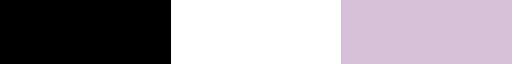

In [159]:
cmap = ListedColormap(
    np.array(
        [
            [[0.0, 0.0, 0.0]],
            [[1.0, 1.0, 1.0]],
            [[0.84705882, 0.74901961, 0.84705882]],
        ]
    )
)
cmap

In [160]:
hsi_reshaped = hsi_raw_shadow.reshape(-1, hsi_raw_shadow.shape[-1])
lidar_reshaped = lidar.reshape(-1)
hsi_reshaped.shape, lidar_reshaped.shape

((664845, 149), (664845,))

In [161]:
y_pred = building_classifier.predict(hsi_reshaped)
img_pred = y_pred.reshape(lidar.shape)
img_pred.shape

(349, 1905)

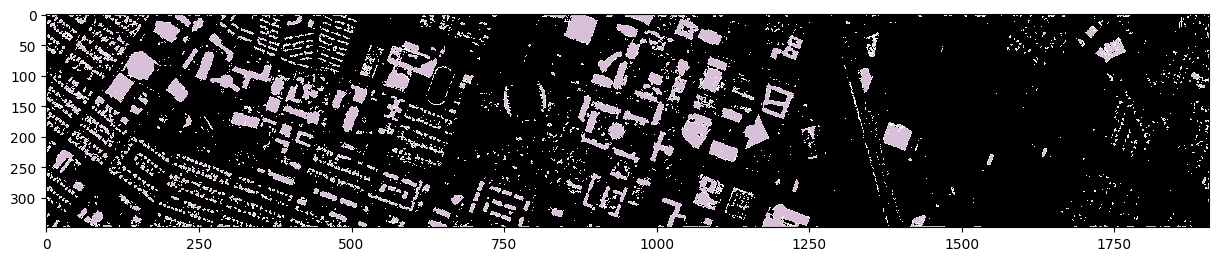

In [162]:
plt.figure(figsize=(15, 15))
plt.imshow(img_pred, cmap=cmap)